# Metrics Migration Testing Notebook (General Purpose)

This notebook provides a **generalized, reusable approach** for comparing legacy and modern metric implementations.

## Quick Start
1. **Edit the Configuration Cell** (cell 2) with your metric details
2. Run all cells - no other modifications needed!
3. Works for ANY metric type: LLM-based, embeddings-based, or deterministic

## Purpose
- **PRIMARY**: Validate migration on real-world datasets (amnesty_qa, fiqa)
- **SECONDARY**: Test specific edge cases and behaviors
- **FLEXIBLE**: Works with any metric configuration

## Structure
1. Configuration (specify your metrics and requirements)
2. Setup and component creation
3. Dataset-based comparison (Amnesty QA)
4. FIQA dataset testing (domain generalization)
5. Optional: Different LLMs, edge cases

Based on: `tests/e2e/plan-for-metrics-migration.md`

In [1]:
import asyncio
import time
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd

# Ragas imports
from ragas.dataset_schema import SingleTurnSample

/Users/jjmachan/workspace/eglabs/ragas-workdir/ragas/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## ⚠️ CONFIGURATION CELL - EDIT THIS FOR YOUR METRIC ⚠️

# Metric Configuration - Update these values for any metric
METRIC_CONFIG = {
    # ===== METRIC IMPORTS =====
    "legacy_import": {
        "module": "ragas.metrics._answer_relevance",  # e.g., "ragas.metrics._context_recall"
        "class_name": "AnswerRelevancy",              # e.g., "ContextRecall"
    },
    "modern_import": {
        "module": "ragas.metrics.collections",
        "class_name": "AnswerRelevancy",
    },
    
    # ===== COMPONENT REQUIREMENTS =====
    # Set to False if your metric doesn't need this component
    "needs_llm": True,
    "needs_embeddings": True,
    
    # ===== DATASET FIELD MAPPING =====
    # Which fields does your metric require from the dataset?
    # Choose ONE based on your metric type:
    
    # OPTION 1: Answer-based metrics (AnswerRelevancy, AnswerSimilarity, etc.)
    "dataset_fields": ["user_input", "response"],
    
    # OPTION 2: Context-based metrics (ContextRecall, ContextPrecision, etc.)
    # "dataset_fields": ["user_input", "retrieved_contexts", "reference"],
    
    # OPTION 3: Deterministic metrics (NonLLMContextRecall, etc.)
    # "dataset_fields": ["retrieved_contexts", "reference_contexts"],
    # "needs_llm": False,
    # "needs_embeddings": False,
}

# ===== QUICK REFERENCE =====
# AnswerRelevancy: dataset_fields = ["user_input", "response"], needs_llm = True, needs_embeddings = True
# ContextRecall: dataset_fields = ["user_input", "retrieved_contexts", "reference"], needs_llm = True, needs_embeddings = False
# NonLLMContextRecall: dataset_fields = ["retrieved_contexts", "reference_contexts"], needs_llm = False, needs_embeddings = False
# ContextPrecision: dataset_fields = ["user_input", "retrieved_contexts", "reference"], needs_llm = True, needs_embeddings = False

print("✓ Configuration loaded - Edit above for your metric")

✓ Configuration loaded - Edit above for your metric


## Setup

Make sure you have your OpenAI API key set as an environment variable before running this notebook.

In [3]:
import os
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from tests.utils import check_api_key

# Check for OpenAI API key
check_api_key("openai")
print("✓ Setup complete")

# ===== DYNAMIC METRIC LOADING =====
def load_metric_class(import_config):
    """Dynamically load a metric class from module and class name."""
    try:
        module = importlib.import_module(import_config["module"])
        return getattr(module, import_config["class_name"])
    except (ImportError, AttributeError) as e:
        raise ValueError(f"Failed to load {import_config['class_name']} from {import_config['module']}: {e}")

# Load metric classes from config
LegacyMetric = load_metric_class(METRIC_CONFIG["legacy_import"])
ModernMetric = load_metric_class(METRIC_CONFIG["modern_import"])

print(f"✓ Metric classes loaded:")
print(f"  Legacy: {METRIC_CONFIG['legacy_import']['class_name']} from {METRIC_CONFIG['legacy_import']['module']}")
print(f"  Modern: {METRIC_CONFIG['modern_import']['class_name']} from {METRIC_CONFIG['modern_import']['module']}")

✓ Setup complete
✓ Metric classes loaded:
  Legacy: AnswerRelevancy from ragas.metrics._answer_relevance
  Modern: AnswerRelevancy from ragas.metrics.collections


## Import Comparison Utilities

The `compare_metrics` function is imported from `tests.utils` and provides:
- Concurrent processing for better performance
- Parallel or sequential metric execution
- Built-in result aggregation and statistics

In [5]:
from tests.utils import compare_metrics

print("✓ Comparison utilities loaded")

✓ Comparison utilities loaded


## Create LLM and Embeddings Components

Use shared test utilities to create legacy and modern components based on configuration.

In [6]:
from tests.utils import (
    create_legacy_embeddings,
    create_legacy_llm,
    create_modern_embeddings,
    create_modern_llm,
)

# ===== CREATE COMPONENTS BASED ON CONFIGURATION =====
components_config = {
    "legacy_llm": None,
    "legacy_embeddings": None,
    "modern_llm": None,
    "modern_embeddings": None,
}

if METRIC_CONFIG["needs_llm"]:
    components_config["legacy_llm"] = create_legacy_llm(model="gpt-4o-mini")
    components_config["modern_llm"] = create_modern_llm(provider="openai", model="gpt-4o-mini")
    print("✓ LLM components created")

if METRIC_CONFIG["needs_embeddings"]:
    components_config["legacy_embeddings"] = create_legacy_embeddings(model="text-embedding-ada-002")
    components_config["modern_embeddings"] = create_modern_embeddings(
        provider="openai", model="text-embedding-ada-002"
    )
    print("✓ Embeddings components created")

print("✓ All required components created")

✓ LLM components created
✓ Embeddings components created
✓ All required components created


## Initialize Metrics

Uses the dynamically loaded metric classes and configured components.

In [7]:
# ===== INITIALIZE METRICS DYNAMICALLY =====
def init_metric(metric_class, components_config, is_legacy=True):
    """Initialize a metric with available components."""
    prefix = "legacy_" if is_legacy else "modern_"
    
    # Build kwargs from available components
    kwargs = {}
    if components_config[f"{prefix}llm"]:
        kwargs["llm"] = components_config[f"{prefix}llm"]
    if components_config[f"{prefix}embeddings"]:
        kwargs["embeddings"] = components_config[f"{prefix}embeddings"]
    
    return metric_class(**kwargs)

# Initialize metrics
legacy_metric = init_metric(LegacyMetric, components_config, is_legacy=True)
modern_metric = init_metric(ModernMetric, components_config, is_legacy=False)

# Display initialized metrics
legacy_name = getattr(legacy_metric, 'name', legacy_metric.__class__.__name__)
modern_name = getattr(modern_metric, 'name', modern_metric.__class__.__name__)

print(f"✓ Metrics initialized:")
print(f"  Legacy: {legacy_name}")
print(f"  Modern: {modern_name}")
print(f"  Dataset fields required: {METRIC_CONFIG['dataset_fields']}")

✓ Metrics initialized:
  Legacy: answer_relevancy
  Modern: answer_relevancy
  Dataset fields required: ['user_input', 'response']


In [8]:
# Import metrics
from ragas.metrics._answer_relevance import AnswerRelevancy as LegacyAnswerRelevancy
from ragas.metrics.collections import AnswerRelevancy

# Initialize metrics
legacy_metric = LegacyAnswerRelevancy(
    llm=legacy_llm, embeddings=legacy_embeddings, strictness=3
)
new_metric = AnswerRelevancy(
    llm=modern_llm, embeddings=modern_embeddings, strictness=3
)

print(f"Legacy metric: {legacy_metric.name}")
print(f"New metric: {new_metric.name}")
print("✓ Metrics initialized")

NameError: name 'legacy_llm' is not defined

---

## PRIMARY: Dataset-Based Testing

### Load Amnesty QA Dataset

In [ ]:
from tests.e2e.test_dataset_utils import load_amnesty_dataset_safe

print("Loading amnesty_qa dataset...")
amnesty_dataset = load_amnesty_dataset_safe("english_v3")
print(f"✓ Loaded {len(amnesty_dataset)} samples from amnesty_qa")

# Convert to format expected by metric using configured fields
amnesty_test_data = []
for i, sample in enumerate(amnesty_dataset):
    if i >= 20:  # Start with 20 samples, adjust as needed
        break
    
    # Extract only configured fields
    test_sample = {}
    for field in METRIC_CONFIG["dataset_fields"]:
        if field == "reference_contexts" and field not in sample:
            # Handle transform case: split retrieved_contexts
            retrieved_contexts = sample.get("retrieved_contexts", [])
            if retrieved_contexts and len(retrieved_contexts) > 1:
                mid = len(retrieved_contexts) // 2
                test_sample[field] = retrieved_contexts[mid:]
        elif field in sample:
            test_sample[field] = sample[field]
        elif field == "response":
            # Default for response if not in sample
            test_sample[field] = sample.get("response", "")
        elif field == "reference":
            # Rename reference_contexts to reference if needed
            test_sample[field] = sample.get("reference_contexts", sample.get("reference", ""))
    
    if test_sample:  # Only add if we have data
        amnesty_test_data.append(test_sample)

print(f"✓ Prepared {len(amnesty_test_data)} samples for testing")
if amnesty_test_data:
    print(f"\nFirst sample fields:")
    first_sample = amnesty_test_data[0]
    for key, value in first_sample.items():
        if isinstance(value, list):
            print(f"  {key}: {len(value)} item(s)")
        elif isinstance(value, str):
            print(f"  {key}: {value[:80]}...")
        else:
            print(f"  {key}: {value}")

### Compare on Amnesty QA (Optimized & Parallel)


In [ ]:

print("\n" + "="*70)
print("AMNESTY QA DATASET COMPARISON")
print("="*70)
print(f"Dataset: {len(amnesty_test_data)} samples")
print("Mode: Concurrent processing + Parallel metrics")
print("="*70)

amnesty_result = await compare_metrics(
    old_metric=legacy_metric,
    new_metric=new_metric,
    dataset=amnesty_test_data,
    old_metric_type="old",
    new_metric_type="new",
    max_concurrent=10,
    parallel_metrics=True,
)

amnesty_result.print_summary()


AMNESTY QA DATASET COMPARISON
Dataset: 20 samples
Mode: Concurrent processing + Parallel metrics
Running both metrics in parallel on 20 samples (max 10 concurrent)...
METRIC COMPARISON SUMMARY

Score Statistics:
  Old Metric Mean: 0.9211
  New Metric Mean: 0.9736

Difference Statistics (new - old):
  Mean Diff:   0.0525
  Max Diff:    0.9992
  Min Diff:    -0.0221
  Std Dev:     0.2174

Execution Time:
  Old Metric:  34.06s
  New Metric:  48.82s
  Speedup:     0.70x


### Analyze Amnesty QA Results in Detail


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get detailed DataFrame
df_amnesty = amnesty_result.to_dataframe()
df_amnesty["sample_idx"] = range(len(df_amnesty))

# Create description from first available string field in your test data
def get_description(sample):
    """Extract a short description from sample data."""
    for key in ["user_input", "response", "reference", "question"]:
        if key in sample and isinstance(sample[key], str):
            return sample[key][:60] + "..."
    return f"Sample with {len(sample)} fields"

df_amnesty["description"] = [get_description(s) for s in amnesty_test_data]

# Statistical Analysis
print("\n" + "="*70)
print("DETAILED STATISTICAL ANALYSIS")
print("="*70)
print(f"\nDataset: amnesty_qa ({len(df_amnesty)} samples)")
print(f"\nScore Statistics:")
print(f"  Legacy Mean:  {amnesty_result.old_mean:.4f}")
print(f"  New Mean:     {amnesty_result.new_mean:.4f}")
print(f"  Score Shift:  {amnesty_result.mean_diff:+.4f}")

print(f"\nDifference Statistics:")
print(f"  Mean |Diff|:  {df_amnesty['abs_diff'].mean():.4f}")
print(f"  Std Dev:      {amnesty_result.std_diff:.4f}")
print(f"  Max Diff:     {amnesty_result.max_diff:.4f}")
print(f"  Min Diff:     {amnesty_result.min_diff:.4f}")
print(f"  Median Diff:  {df_amnesty['abs_diff'].median():.4f}")

# Tolerance Analysis (adjust for your metric type)
# For LLM-based metrics: use [0.1, 0.15, 0.2, 0.25, 0.3]
# For deterministic metrics: use [1e-10, 1e-8, 1e-6, 1e-4, 0.01]
tolerance_levels = [0.1, 0.15, 0.2, 0.25, 0.3]
print(f"\nTolerance Analysis:")
for tol in tolerance_levels:
    within = (df_amnesty["abs_diff"] < tol).sum()
    pct = within / len(df_amnesty) * 100
    print(f"  < {tol:.2f}:  {within:3d}/{len(df_amnesty)} ({pct:5.1f}%)")

# Identify problematic cases
print("\n" + "="*70)
print("TOP 10 LARGEST DIFFERENCES")
print("="*70)
top_diffs = df_amnesty.nlargest(10, "abs_diff")
for idx, row in top_diffs.iterrows():
    print(f"\n#{row['sample_idx']+1}: {row['description']}")
    print(f"  Legacy: {row['old_score']:.4f}  |  New: {row['new_score']:.4f}  |  Diff: {row['abs_diff']:.4f}")


DETAILED STATISTICAL ANALYSIS

Dataset: amnesty_qa (20 samples)

Score Statistics:
  Legacy Mean:  0.9211
  New Mean:     0.9736
  Score Shift:  +0.0525

Difference Statistics:
  Mean |Diff|:  0.0558
  Std Dev:      0.2174
  Max Diff:     0.9992
  Min Diff:     -0.0221
  Median Diff:  0.0026

Tolerance Analysis:
  < 0.10:   19/20 ( 95.0%)
  < 0.15:   19/20 ( 95.0%)
  < 0.20:   19/20 ( 95.0%)
  < 0.25:   19/20 ( 95.0%)
  < 0.30:   19/20 ( 95.0%)

TOP 10 LARGEST DIFFERENCES

#6: Who are the target audience of the two books created by Amne...
  Legacy: 0.0000  |  New: 0.9992  |  Diff: 0.9992

#9: When can individuals be found guilty under Article 207.3 of ...
  Legacy: 0.8999  |  New: 0.9259  |  Diff: 0.0260

#13: Where was COP15 held in 2022?...
  Legacy: 1.0000  |  New: 0.9779  |  Diff: 0.0221

#8: Who has the right to be fully informed about human rights vi...
  Legacy: 0.9374  |  New: 0.9588  |  Diff: 0.0214

#3: Which private companies in the Americas are the largest GHG ...
  Legac

/var/folders/2y/02fp70k56p75ldrkgtx7z10r0000gn/T/ipykernel_82228/1485780648.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax5.boxplot([df_amnesty["old_score"], df_amnesty["new_score"]], labels=['Legacy', 'New'])


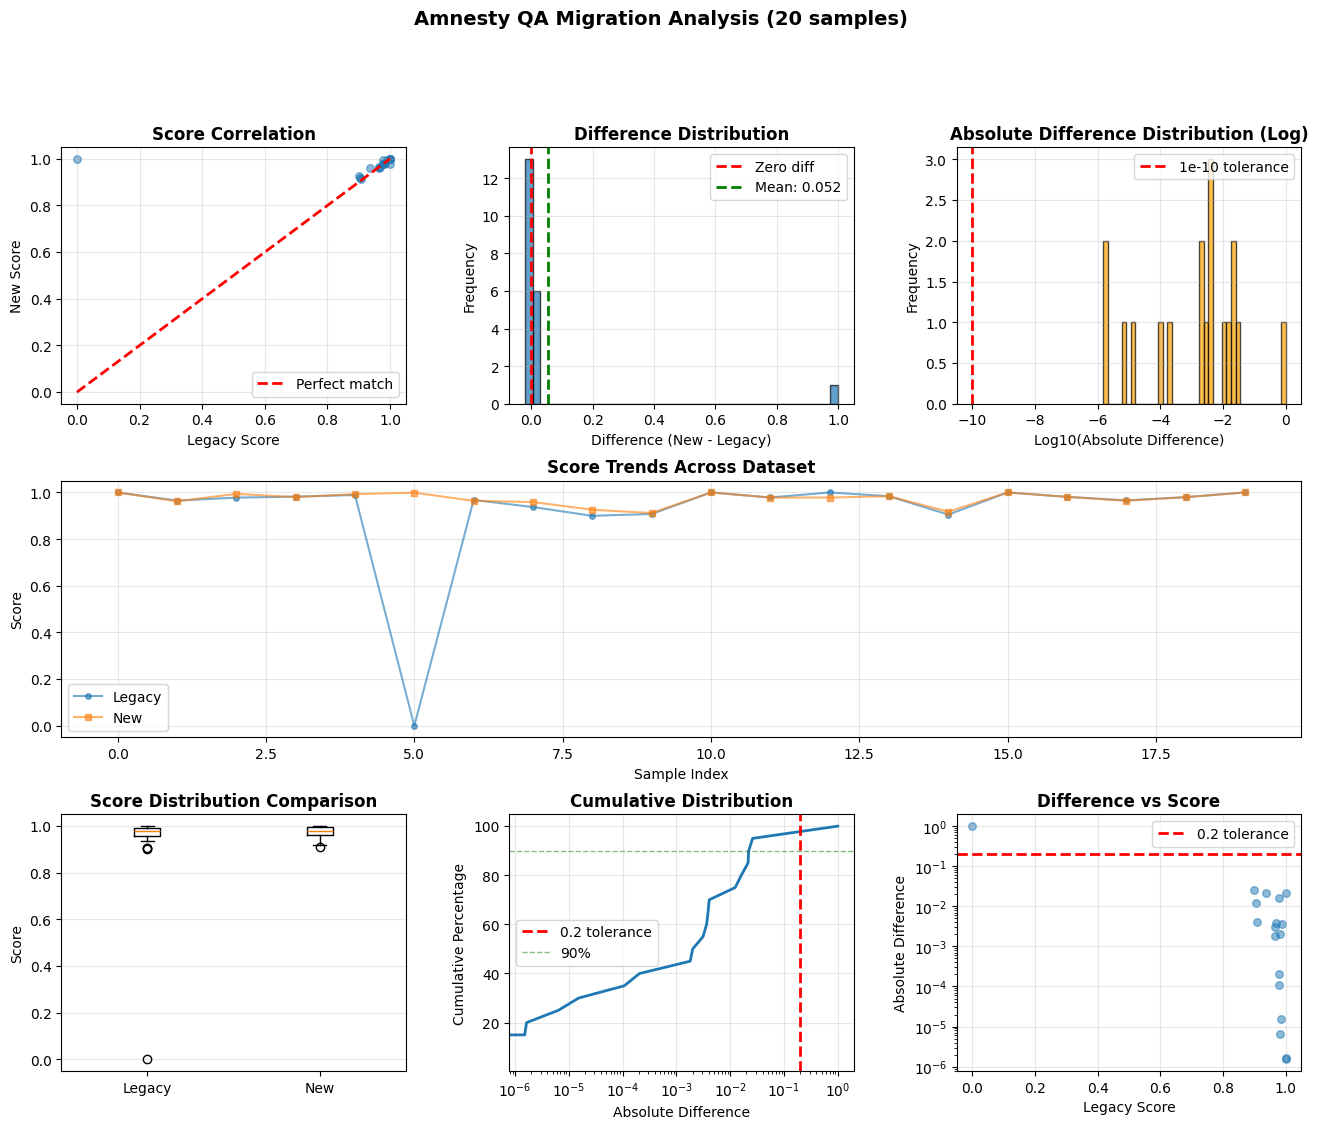

In [ ]:
### Visualize Amnesty QA Results

# Comprehensive Visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Scatter: Legacy vs New scores
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df_amnesty["old_score"], df_amnesty["new_score"], alpha=0.5, s=30)
ax1.plot([0, 1], [0, 1], 'r--', label="Perfect match", linewidth=2)
ax1.set_xlabel("Legacy Score", fontsize=10)
ax1.set_ylabel("New Score", fontsize=10)
ax1.set_title("Score Correlation", fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)

# 2. Histogram: Difference distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df_amnesty["diff"], bins=40, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero diff')
ax2.axvline(x=df_amnesty["diff"].mean(), color='g', linestyle='--', linewidth=2, 
            label=f'Mean: {df_amnesty["diff"].mean():.3f}')
ax2.set_xlabel("Difference (New - Legacy)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Difference Distribution", fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Histogram: Absolute difference (log scale for deterministic metrics)
ax3 = fig.add_subplot(gs[0, 2])
non_zero_diffs = df_amnesty[df_amnesty["abs_diff"] > 0]["abs_diff"]
if len(non_zero_diffs) > 0:
    ax3.hist(np.log10(non_zero_diffs), bins=40, alpha=0.7, color='orange', edgecolor='black')
    ax3.axvline(x=-10, color='r', linestyle='--', linewidth=2, label='1e-10 tolerance')
    ax3.set_xlabel("Log10(Absolute Difference)", fontsize=10)
else:
    ax3.text(0.5, 0.5, 'All differences are zero!', ha='center', va='center', fontsize=12)
ax3.set_ylabel("Frequency", fontsize=10)
ax3.set_title("Absolute Difference Distribution (Log)", fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Line plot: Score trends
ax4 = fig.add_subplot(gs[1, :])
x = df_amnesty["sample_idx"]
ax4.plot(x, df_amnesty["old_score"], 'o-', label="Legacy", alpha=0.6, markersize=4)
ax4.plot(x, df_amnesty["new_score"], 's-', label="New", alpha=0.6, markersize=4)
ax4.set_xlabel("Sample Index", fontsize=10)
ax4.set_ylabel("Score", fontsize=10)
ax4.set_title("Score Trends Across Dataset", fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(-0.05, 1.05)

# 5. Box plots: Score distributions
ax5 = fig.add_subplot(gs[2, 0])
ax5.boxplot([df_amnesty["old_score"], df_amnesty["new_score"]], labels=['Legacy', 'New'])
ax5.set_ylabel("Score", fontsize=10)
ax5.set_title("Score Distribution Comparison", fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Cumulative distribution of absolute differences
ax6 = fig.add_subplot(gs[2, 1])
sorted_diffs = np.sort(df_amnesty["abs_diff"])
cumulative = np.arange(1, len(sorted_diffs) + 1) / len(sorted_diffs) * 100
ax6.plot(sorted_diffs, cumulative, linewidth=2)
ax6.axvline(x=0.2, color='r', linestyle='--', linewidth=2, label='0.2 tolerance')
ax6.axhline(y=90, color='g', linestyle='--', linewidth=1, alpha=0.5, label='90%')
ax6.set_xlabel("Absolute Difference", fontsize=10)
ax6.set_ylabel("Cumulative Percentage", fontsize=10)
ax6.set_title("Cumulative Distribution", fontsize=12, fontweight='bold')
ax6.set_xscale('log')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Scatter: Difference vs Legacy score
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(df_amnesty["old_score"], df_amnesty["abs_diff"], alpha=0.5, s=30)
ax7.axhline(y=0.2, color='r', linestyle='--', linewidth=2, label='0.2 tolerance')
ax7.set_xlabel("Legacy Score", fontsize=10)
ax7.set_ylabel("Absolute Difference", fontsize=10)
ax7.set_title("Difference vs Score", fontsize=12, fontweight='bold')
ax7.set_yscale('log')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.suptitle(f"Amnesty QA Migration Analysis ({len(df_amnesty)} samples)", 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

In [ ]:
### Validate Amnesty QA Results

print("🎯 AMNESTY QA VALIDATION COMPLETE")
print("="*70)
print(f"   Mean |Diff|: {df_amnesty['abs_diff'].mean():.4f}")
print(f"   Within 0.2:  {(df_amnesty['abs_diff'] < 0.2).sum()}/{len(df_amnesty)} "
      f"({(df_amnesty['abs_diff'] < 0.2).sum()/len(df_amnesty)*100:.1f}%)")
print(f"   Within 0.3:  {(df_amnesty['abs_diff'] < 0.3).sum()}/{len(df_amnesty)} "
      f"({(df_amnesty['abs_diff'] < 0.3).sum()/len(df_amnesty)*100:.1f}%)")

# Validation criteria for LLM-based metrics
# For deterministic metrics, use stricter tolerances (1e-10, 1e-6)
mean_abs_diff = df_amnesty['abs_diff'].mean()
pct_within_02 = (df_amnesty['abs_diff'] < 0.2).sum() / len(df_amnesty) * 100
pct_within_03 = (df_amnesty['abs_diff'] < 0.3).sum() / len(df_amnesty) * 100

print("\n📊 Validation Criteria (LLM-based metrics):")
print(f"   {'✅' if mean_abs_diff < 0.15 else '❌'} Mean |diff| < 0.15: {mean_abs_diff:.4f}")
print(f"   {'✅' if pct_within_02 > 90 else '⚠️'} >90% within 0.2: {pct_within_02:.1f}%")
print(f"   {'✅' if pct_within_03 > 95 else '⚠️'} >95% within 0.3: {pct_within_03:.1f}%")
print(f"   {'✅' if abs(amnesty_result.mean_diff) < 0.05 else '⚠️'} "
      f"No systematic bias (|mean diff| < 0.05): {abs(amnesty_result.mean_diff):.4f}")

print("\n💡 For deterministic metrics, use stricter criteria:")
print("   - Mean |diff| < 1e-10")
print("   - 100% within 1e-10")

🎯 AMNESTY QA VALIDATION COMPLETE
   Mean |Diff|: 0.0558
   Within 0.2:  19/20 (95.0%)
   Within 0.3:  19/20 (95.0%)

📊 Validation Criteria (LLM-based metrics):
   ✅ Mean |diff| < 0.15: 0.0558
   ✅ >90% within 0.2: 95.0%
   ⚠️ >95% within 0.3: 95.0%
   ⚠️ No systematic bias (|mean diff| < 0.05): 0.0525

💡 For deterministic metrics, use stricter criteria:
   - Mean |diff| < 1e-10
   - 100% within 1e-10


---

## FIQA Dataset Testing (Domain Generalization)

Test on financial Q&A dataset to validate metric works across different domains.

In [ ]:
### Load FIQA Dataset

from tests.e2e.test_dataset_utils import load_fiqa_dataset_safe

print("\n" + "="*70)
print("FIQA DATASET COMPARISON")
print("="*70)
print("Testing on financial Q&A dataset for domain generalization...")

fiqa_dataset = load_fiqa_dataset_safe("ragas_eval_v3")
print(f"✓ Loaded {len(fiqa_dataset)} samples from fiqa")

# Convert to format expected by metric using configured fields
fiqa_test_data = []
for i, sample in enumerate(fiqa_dataset):
    if i >= 30:  # Use up to 30 samples from ragas_eval_v3
        break
    
    # Extract only configured fields (same logic as Amnesty QA)
    test_sample = {}
    for field in METRIC_CONFIG["dataset_fields"]:
        if field == "reference_contexts" and field not in sample:
            # Handle transform case: split retrieved_contexts
            retrieved_contexts = sample.get("retrieved_contexts", [])
            if retrieved_contexts and len(retrieved_contexts) > 1:
                mid = len(retrieved_contexts) // 2
                test_sample[field] = retrieved_contexts[mid:]
            elif retrieved_contexts:
                test_sample[field] = retrieved_contexts
        elif field in sample:
            test_sample[field] = sample[field]
        elif field == "response":
            test_sample[field] = sample.get("response", "")
        elif field == "reference":
            test_sample[field] = sample.get("reference_contexts", sample.get("reference", ""))
    
    if test_sample:  # Only add if we have data
        fiqa_test_data.append(test_sample)

print(f"✓ Prepared {len(fiqa_test_data)} samples for testing")
if fiqa_test_data:
    print(f"\nFirst sample fields:")
    first_sample = fiqa_test_data[0]
    for key, value in first_sample.items():
        if isinstance(value, list):
            print(f"  {key}: {len(value)} item(s)")
        elif isinstance(value, str):
            print(f"  {key}: {value[:80]}...")
        else:
            print(f"  {key}: {value}")

In [ ]:
### Compare on FIQA (Optimized & Parallel)

print("\n" + "="*70)
print(f"Dataset: {len(fiqa_test_data)} samples")
print("Mode: Concurrent processing + Parallel metrics")
print("="*70)

fiqa_result = await compare_metrics(
    old_metric=legacy_metric,
    new_metric=new_metric,
    dataset=fiqa_test_data,
    old_metric_type="old",
    new_metric_type="new",
    max_concurrent=10,
    parallel_metrics=True,
)

fiqa_result.print_summary()


Dataset: 30 samples
Mode: Concurrent processing + Parallel metrics
Running both metrics in parallel on 30 samples (max 10 concurrent)...
METRIC COMPARISON SUMMARY

Score Statistics:
  Old Metric Mean: 0.7542
  New Metric Mean: 0.7887

Difference Statistics (new - old):
  Mean Diff:   0.0346
  Max Diff:    0.9577
  Min Diff:    -0.0120
  Std Dev:     0.1716

Execution Time:
  Old Metric:  33.05s
  New Metric:  58.09s
  Speedup:     0.57x


In [ ]:
### Analyze FIQA Results in Detail

# Get detailed DataFrame
df_fiqa = fiqa_result.to_dataframe()
df_fiqa["sample_idx"] = range(len(df_fiqa))
df_fiqa["description"] = [get_description(s) for s in fiqa_test_data]

# Statistical Analysis
print("\n" + "="*70)
print("DETAILED STATISTICAL ANALYSIS")
print("="*70)
print(f"\nDataset: fiqa ({len(df_fiqa)} samples)")
print(f"\nScore Statistics:")
print(f"  Legacy Mean:  {fiqa_result.old_mean:.4f}")
print(f"  New Mean:     {fiqa_result.new_mean:.4f}")
print(f"  Score Shift:  {fiqa_result.mean_diff:+.4f}")

print(f"\nDifference Statistics:")
print(f"  Mean |Diff|:  {df_fiqa['abs_diff'].mean():.4f}")
print(f"  Std Dev:      {fiqa_result.std_diff:.4f}")
print(f"  Max Diff:     {fiqa_result.max_diff:.4f}")
print(f"  Min Diff:     {fiqa_result.min_diff:.4f}")
print(f"  Median Diff:  {df_fiqa['abs_diff'].median():.4f}")

# Tolerance Analysis (adjust for your metric type)
# For LLM-based metrics: use [0.1, 0.15, 0.2, 0.25, 0.3]
# For deterministic metrics: use [1e-10, 1e-8, 1e-6, 1e-4, 0.01]
tolerance_levels = [0.1, 0.15, 0.2, 0.25, 0.3]
print(f"\nTolerance Analysis:")
for tol in tolerance_levels:
    within = (df_fiqa["abs_diff"] < tol).sum()
    pct = within / len(df_fiqa) * 100
    print(f"  < {tol:.2f}:  {within:3d}/{len(df_fiqa)} ({pct:5.1f}%)")

# Identify problematic cases
print("\n" + "="*70)
print("TOP 10 LARGEST DIFFERENCES")
print("="*70)
top_diffs = df_fiqa.nlargest(10, "abs_diff")
for idx, row in top_diffs.iterrows():
    print(f"\n#{row['sample_idx']+1}: {row['description']}")
    print(f"  Legacy: {row['old_score']:.4f}  |  New: {row['new_score']:.4f}  |  Diff: {row['abs_diff']:.4f}")


DETAILED STATISTICAL ANALYSIS

Dataset: fiqa (30 samples)

Score Statistics:
  Legacy Mean:  0.7542
  New Mean:     0.7887
  Score Shift:  +0.0346

Difference Statistics:
  Mean |Diff|:  0.0364
  Std Dev:      0.1716
  Max Diff:     0.9577
  Min Diff:     -0.0120
  Median Diff:  0.0029

Tolerance Analysis:
  < 0.10:   29/30 ( 96.7%)
  < 0.15:   29/30 ( 96.7%)
  < 0.20:   29/30 ( 96.7%)
  < 0.25:   29/30 ( 96.7%)
  < 0.30:   29/30 ( 96.7%)

TOP 10 LARGEST DIFFERENCES

#11: Using credit card points to pay for tax deductible business ...
  Legacy: 0.0000  |  New: 0.9577  |  Diff: 0.9577

#8: Intentions of Deductible Amount for Small Business...
  Legacy: 0.9299  |  New: 0.9501  |  Diff: 0.0202

#4: Applying for and receiving business credit...
  Legacy: 0.9126  |  New: 0.9284  |  Diff: 0.0158

#2: Can I send a money order from USPS as a business?...
  Legacy: 0.9660  |  New: 0.9810  |  Diff: 0.0151

#3: 1 EIN doing business under multiple business names...
  Legacy: 0.9348  |  New: 0.948

/var/folders/2y/02fp70k56p75ldrkgtx7z10r0000gn/T/ipykernel_82228/2878535787.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax5.boxplot([df_fiqa["old_score"], df_fiqa["new_score"]], labels=['Legacy', 'New'])


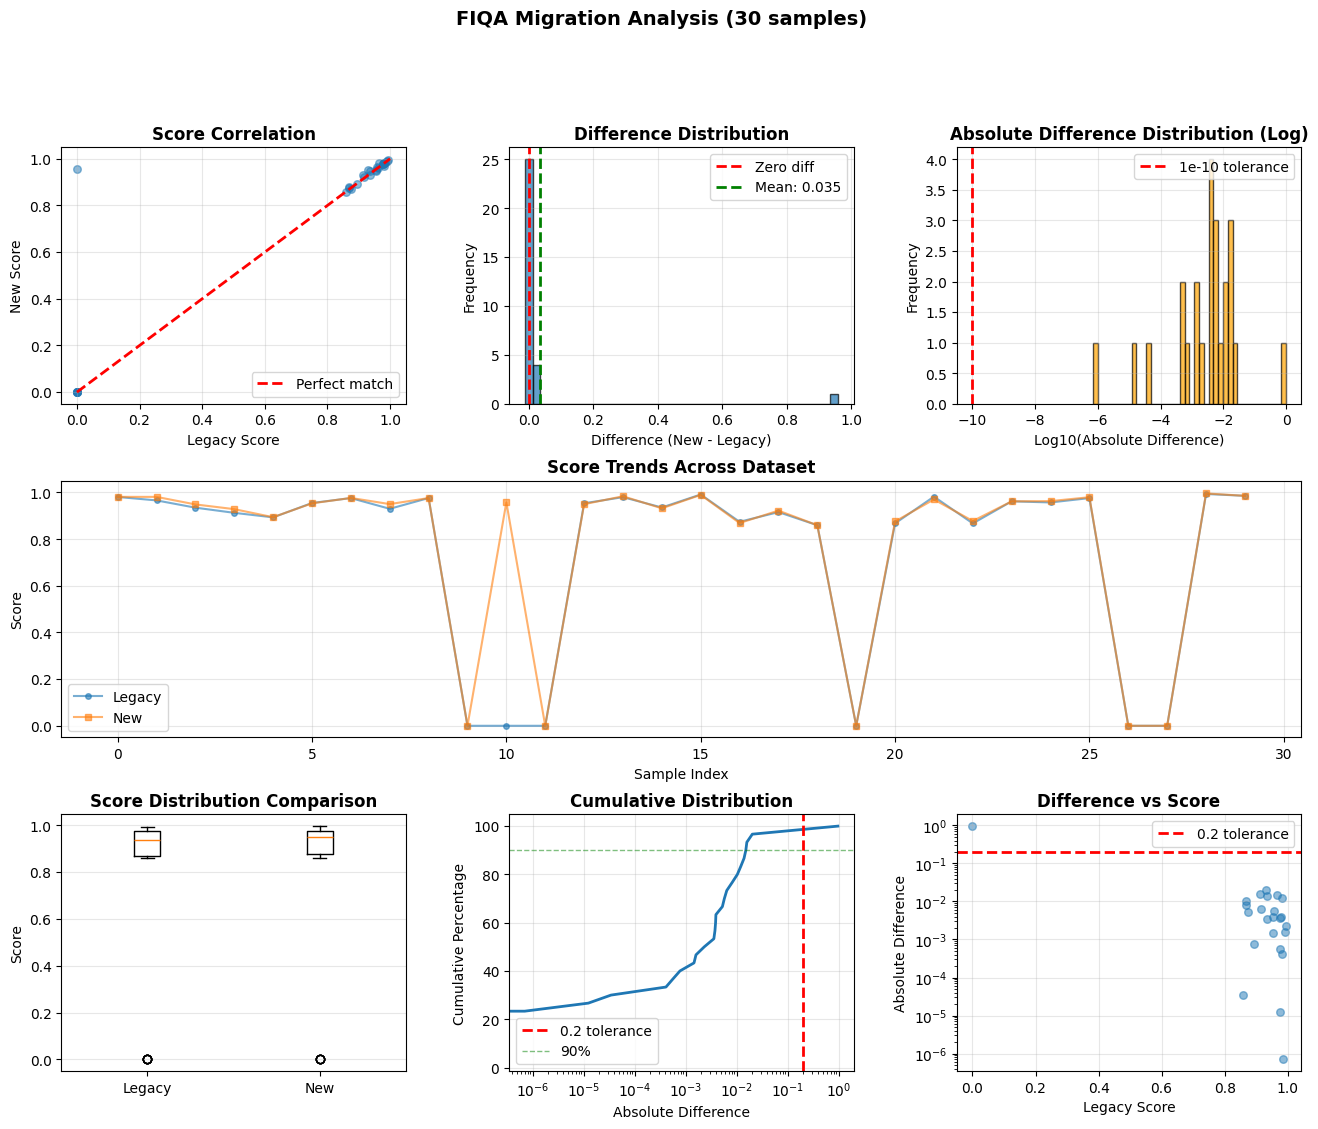

In [ ]:
### Visualize FIQA Results

# Comprehensive Visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Scatter: Legacy vs New scores
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(df_fiqa["old_score"], df_fiqa["new_score"], alpha=0.5, s=30)
ax1.plot([0, 1], [0, 1], 'r--', label="Perfect match", linewidth=2)
ax1.set_xlabel("Legacy Score", fontsize=10)
ax1.set_ylabel("New Score", fontsize=10)
ax1.set_title("Score Correlation", fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)

# 2. Histogram: Difference distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df_fiqa["diff"], bins=40, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero diff')
ax2.axvline(x=df_fiqa["diff"].mean(), color='g', linestyle='--', linewidth=2, 
            label=f'Mean: {df_fiqa["diff"].mean():.3f}')
ax2.set_xlabel("Difference (New - Legacy)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Difference Distribution", fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Histogram: Absolute difference (log scale for deterministic metrics)
ax3 = fig.add_subplot(gs[0, 2])
non_zero_diffs = df_fiqa[df_fiqa["abs_diff"] > 0]["abs_diff"]
if len(non_zero_diffs) > 0:
    ax3.hist(np.log10(non_zero_diffs), bins=40, alpha=0.7, color='orange', edgecolor='black')
    ax3.axvline(x=-10, color='r', linestyle='--', linewidth=2, label='1e-10 tolerance')
    ax3.set_xlabel("Log10(Absolute Difference)", fontsize=10)
else:
    ax3.text(0.5, 0.5, 'All differences are zero!', ha='center', va='center', fontsize=12)
ax3.set_ylabel("Frequency", fontsize=10)
ax3.set_title("Absolute Difference Distribution (Log)", fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Line plot: Score trends
ax4 = fig.add_subplot(gs[1, :])
x = df_fiqa["sample_idx"]
ax4.plot(x, df_fiqa["old_score"], 'o-', label="Legacy", alpha=0.6, markersize=4)
ax4.plot(x, df_fiqa["new_score"], 's-', label="New", alpha=0.6, markersize=4)
ax4.set_xlabel("Sample Index", fontsize=10)
ax4.set_ylabel("Score", fontsize=10)
ax4.set_title("Score Trends Across Dataset", fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(-0.05, 1.05)

# 5. Box plots: Score distributions
ax5 = fig.add_subplot(gs[2, 0])
ax5.boxplot([df_fiqa["old_score"], df_fiqa["new_score"]], labels=['Legacy', 'New'])
ax5.set_ylabel("Score", fontsize=10)
ax5.set_title("Score Distribution Comparison", fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Cumulative distribution of absolute differences
ax6 = fig.add_subplot(gs[2, 1])
sorted_diffs = np.sort(df_fiqa["abs_diff"])
cumulative = np.arange(1, len(sorted_diffs) + 1) / len(sorted_diffs) * 100
ax6.plot(sorted_diffs, cumulative, linewidth=2)
ax6.axvline(x=0.2, color='r', linestyle='--', linewidth=2, label='0.2 tolerance')
ax6.axhline(y=90, color='g', linestyle='--', linewidth=1, alpha=0.5, label='90%')
ax6.set_xlabel("Absolute Difference", fontsize=10)
ax6.set_ylabel("Cumulative Percentage", fontsize=10)
ax6.set_title("Cumulative Distribution", fontsize=12, fontweight='bold')
ax6.set_xscale('log')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Scatter: Difference vs Legacy score
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(df_fiqa["old_score"], df_fiqa["abs_diff"], alpha=0.5, s=30)
ax7.axhline(y=0.2, color='r', linestyle='--', linewidth=2, label='0.2 tolerance')
ax7.set_xlabel("Legacy Score", fontsize=10)
ax7.set_ylabel("Absolute Difference", fontsize=10)
ax7.set_title("Difference vs Score", fontsize=12, fontweight='bold')
ax7.set_yscale('log')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.suptitle(f"FIQA Migration Analysis ({len(df_fiqa)} samples)", 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()



In [ ]:
### Validate FIQA Results

print("🎯 FIQA VALIDATION COMPLETE")
print("="*70)
print(f"   Mean |Diff|: {df_fiqa['abs_diff'].mean():.4f}")
print(f"   Within 0.2:  {(df_fiqa['abs_diff'] < 0.2).sum()}/{len(df_fiqa)} "
      f"({(df_fiqa['abs_diff'] < 0.2).sum()/len(df_fiqa)*100:.1f}%)")
print(f"   Within 0.3:  {(df_fiqa['abs_diff'] < 0.3).sum()}/{len(df_fiqa)} "
      f"({(df_fiqa['abs_diff'] < 0.3).sum()/len(df_fiqa)*100:.1f}%)")

# Validation criteria for LLM-based metrics
mean_abs_diff = df_fiqa['abs_diff'].mean()
pct_within_02 = (df_fiqa['abs_diff'] < 0.2).sum() / len(df_fiqa) * 100
pct_within_03 = (df_fiqa['abs_diff'] < 0.3).sum() / len(df_fiqa) * 100

print("\n📊 Validation Criteria (LLM-based metrics):")
print(f"   {'✅' if mean_abs_diff < 0.15 else '❌'} Mean |diff| < 0.15: {mean_abs_diff:.4f}")
print(f"   {'✅' if pct_within_02 > 90 else '⚠️'} >90% within 0.2: {pct_within_02:.1f}%")
print(f"   {'✅' if pct_within_03 > 95 else '⚠️'} >95% within 0.3: {pct_within_03:.1f}%")
print(f"   {'✅' if abs(fiqa_result.mean_diff) < 0.05 else '⚠️'} "
      f"No systematic bias (|mean diff| < 0.05): {abs(fiqa_result.mean_diff):.4f}")

print("\n💡 Domain Generalization Check:")
print(f"   ✅ Amnesty QA Mean |Diff|: {df_amnesty['abs_diff'].mean():.4f}")
print(f"   ✅ FIQA Mean |Diff|:       {df_fiqa['abs_diff'].mean():.4f}")
print(f"   {'✅' if abs(df_amnesty['abs_diff'].mean() - df_fiqa['abs_diff'].mean()) < 0.1 else '⚠️'} "
      f"Consistent across domains")



🎯 FIQA VALIDATION COMPLETE
   Mean |Diff|: 0.0364
   Within 0.2:  29/30 (96.7%)
   Within 0.3:  29/30 (96.7%)

📊 Validation Criteria (LLM-based metrics):
   ✅ Mean |diff| < 0.15: 0.0364
   ✅ >90% within 0.2: 96.7%
   ✅ >95% within 0.3: 96.7%
   ✅ No systematic bias (|mean diff| < 0.05): 0.0346

💡 Domain Generalization Check:
   ✅ Amnesty QA Mean |Diff|: 0.0558
   ✅ FIQA Mean |Diff|:       0.0364
   ✅ Consistent across domains
